<a href="https://colab.research.google.com/github/antonFJohansson/Please-Stop-Permuting-Features/blob/master/Please_Stop_Permuting_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### What I learned from this article
* There are commonly used measures to gauge feature importance of different models, these do not work that well if the featurs are correlated. They work well though if the features are independent.
* Variable Importance (VI) is obtained by randomizing a feature column in our data matrix. The main issue is that if the features are correlated the randomization will predict values in areas where we haven't observed any data, thereby extrapolating all behaviour. An issue if we work with a model with high capacity such as random forest
* Partial Dependence plot (PD) sets all values of a column to $x$ and measures the average prediction when $x$ is changed. This works well when the features are independent as before,. It will allow us to see how a single feature affects the prediction, like changing the year when a bike was produced and seeing how that affects the final price of that bike. Since it is important to check if we are plotting the new values in a region where we trained on data, it can be a good idea to plot the training datapoints underneath the plot to see where we can draw valid conclusions.
* Linear models are robust to these changes and give similar prediction of feature importance no matter what the correlation is.
* For linear models one can prove that 
$$\mathbb{E}_{\pi}VI_j^{\pi} = 2\hat{\beta}_j^2 \sum_i (x_{ij}-\bar{x}_j)^2$$
Thus we see that this measure of importance of features in linear models is related to the size of the coefficients.
* In order to get some alternatives to these methods we can do a variety of different procedures. These procedures are often quite difficult to work with though and may require more computations.
*One such alternatives is to change a column but to generate the new $x$ from the conditional distribution as $x_{ij} \sim x_{ij}|x_{i,-j}$. The issue lies in obtaining this distribution/approximating it.
* Another method is to drop the feature column entirely and then learn a completely new model and measure the difference in loss. This is time consuming though for large models. Similarly one can permute a column and then relearn a new model as well. It is also possible to simulate a column from the conditional distribution as above and then relearn a new model as well.

In [0]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [0]:
## Class for the feature relevance measure
class featureRelevance():
  
  def __init__(self, X, y, L):
    self.X = X
    self.y = y
    self.L = L
    
  ## Variable Importance function
  def VI(self, f, j):
    X_shuffle = np.copy(self.X)
    shuffle_col=np.copy(X_shuffle[:,j])
    np.random.shuffle(shuffle_col)
    
    X_shuffle[:,j] = shuffle_col
    
    loss_1 = self.L(y, f(X_shuffle))
    loss_2 = self.L(y, f(self.X))
    VI = loss_1-loss_2
    return VI

  ## Partial Dependence function
  def PD(self, x, f, j):  
    X_pd = self.X
    X_n = np.stack([X for k in range(x.shape[0])],0)
    one_vec = x*np.ones((X_n.shape[1], X_n.shape[0]))
    X_n[:,:,j] = np.transpose(one_vec)
    
    
    pd_store = np.zeros(X_n.shape[0])
    
    for iii in range(X_n.shape[0]):
      X_s = np.copy(X_n[iii,:,:])
      pd = np.mean(f(X_s))
      pd_store[iii] = pd
    return pd_store
  
  ## ICE function
  def ICE(self, x, f, j, i):
    X_pd = self.X
    X_n = np.stack([X for k in range(x.shape[0])],0)
    one_vec = x*np.ones((X_n.shape[1], X_n.shape[0]))
    X_n[:,:,j] = np.transpose(one_vec)
    
    
    pd_store = np.zeros(X_n.shape[0])
    
    for iii in range(X_n.shape[0]):
      X_s = np.copy(X_n[iii,:,:])
      pd = f(X_s)[i]
      pd_store[iii] = pd
    return pd_store
    
def loss_fn(x, y):
  p1 = (x - y)**2
  p2 = np.mean(p1)
  return p2
  
  


In [0]:
## Construct the data here


M=20 ## Num simulations
N = 2000 ## Num datapoints

## Parameters for the multivariate Gaussian
mean_vec = np.zeros(2)
cov_matr = np.ones((2,2))
rho = [0, 0.9]

## Storage variables
vi_rf = np.zeros((2, M, 10))
vi_reg = np.zeros((2, M, 10))

for cov_idx, rho in enumerate(rho):
  cov_matr[0,1] = rho
  cov_matr[1,0] = rho
  
  for sim_idx in range(M):
    x3, x4, x5, x6, x7, x8, x9, x10 = np.random.uniform(0, 1, (8, N))
    x1,x2=np.transpose(np.random.multivariate_normal(mean_vec, cov_matr, N))
    x1 = scipy.stats.norm.cdf(x1)
    x2 = scipy.stats.norm.cdf(x2)
    y = x1 + x2 + x3 + x4 + x5 + 0*x6 + 0.5*x7 + 0.8*x8 + 1.2*x9 + 1.5*x10 + np.random.normal(0,0.1,N)
    X = np.transpose(np.array((x1, x2, x3, x4, x5, x6, x7, x8, x9, x10)))
    relevance = featureRelevance(X, y, loss_fn)

    clf = RandomForestRegressor(n_estimators=100)
    clf.fit(X, y)
    rf_predict = clf.predict

    reg = LinearRegression().fit(X, y)
    reg_predict = reg.predict


    for feat_ind in range(10):
      vi1 = relevance.VI(rf_predict, feat_ind)
      vi_rf[cov_idx,sim_idx, feat_ind] = vi1
      vi2 = relevance.VI(reg_predict, feat_ind)
      vi_reg[cov_idx,sim_idx, feat_ind] = vi2

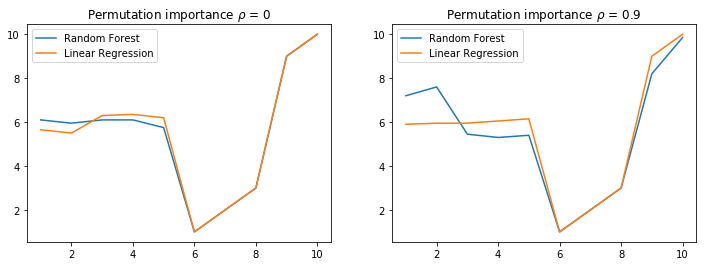

In [0]:
## To plot the result

order = vi_rf.argsort()
ranks = order.argsort()
mean_rank_rf = np.mean(ranks, 1) + 1

order = vi_reg.argsort()
ranks = order.argsort()
mean_rank_reg = np.mean(ranks, 1) + 1

x_plot = [jjj for jjj in range(1,11)]
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
ax = axs[0]
ax.plot(x_plot, mean_rank_rf[0], label = 'Random Forest')
ax.plot(x_plot, mean_rank_reg[0], label = 'Linear Regression')
ax.set_title(r'Permutation importance $\rho$ = 0')
ax.legend()

ax = axs[1]
ax.plot(x_plot, mean_rank_rf[1], label = 'Random Forest')
ax.plot(x_plot, mean_rank_reg[1], label = 'Linear Regression')
ax.set_title(r'Permutation importance $\rho$ = 0.9')
ax.legend()
fig.set_size_inches(12, 4, forward=True)
plt.show()



We see in the above Figures that there is an effect on the calculated importance of the features. The features $x_1$ and $x_2$ are seen to have a higher importance rank when there is a larger correlation for the random forest method. This is only due to the correlation between the features, making it so that the function extrapolates to unknown regions when it calculates the importance measure.

In [0]:

## Construct the data here


M=20 ## Num simulations
N = [100, 200, 500, 1000] ## Num datapoints

## Parameters for the multivariate Gaussian
mean_vec = np.zeros(2)
cov_matr = np.ones((2,2))
rho_l = [0, 0.1, 0.25, 0.35, 0.5, 0.75, 0.9]

## Amount of features that we have in the model
num_features = 10

## To store the result
vi_rf = np.zeros((len(N), len(rho_l), M, num_features))
vi_reg = np.zeros((len(N), len(rho_l), M, num_features))

for sample_ind, sample in enumerate(N):
  for cov_idx, rho in enumerate(rho_l):
    cov_matr[0,1] = rho
    cov_matr[1,0] = rho

    for sim_idx in range(M):
      x3, x4, x5, x6, x7, x8, x9, x10 = np.random.uniform(0, 1, (8, sample))
      x1,x2=np.transpose(np.random.multivariate_normal(mean_vec, cov_matr, sample))
      x1 = scipy.stats.norm.cdf(x1)
      x2 = scipy.stats.norm.cdf(x2)
      y = 0.8*x1 + 0.8*x2 + x3 + x4 + x5 + 0*x6 + 0.5*x7 + 0.8*x8 + 1.2*x9 + 1.5*x10 + np.random.normal(0, 0.1, sample)
      X = np.transpose(np.array((x1, x2, x3, x4, x5, x6, x7, x8, x9, x10)))
      relevance = featureRelevance(X, y, loss_fn)

      clf = RandomForestRegressor(n_estimators=100)
      clf.fit(X, y)
      rf_predict = clf.predict

      reg = LinearRegression().fit(X, y)
      reg_predict = reg.predict


      for feat_ind in range(num_features):
        vi1 = relevance.VI(rf_predict, feat_ind)
        vi_rf[sample_ind,cov_idx,sim_idx, feat_ind] = vi1
        vi2 = relevance.VI(reg_predict, feat_ind)
        vi_reg[sample_ind, cov_idx,sim_idx, feat_ind] = vi2

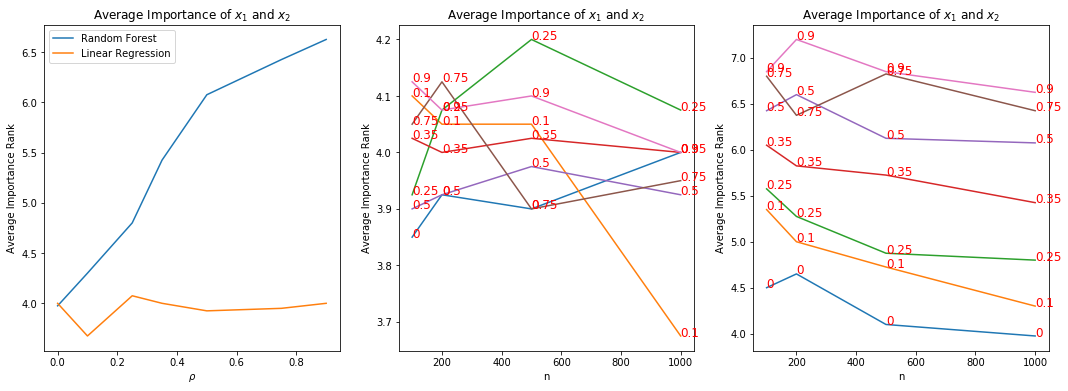

In [13]:
## To plot the result

order = vi_rf.argsort()
ranks = order.argsort()
mean_rank_rf = np.mean(ranks, 2) + 1
mean_rank_rf = np.mean(mean_rank_rf[:,:,0:2],2)

order = vi_reg.argsort()
ranks = order.argsort()
mean_rank_reg = np.mean(ranks, 2) + 1
mean_rank_reg = np.mean(mean_rank_reg[:,:,0:2],2)

fig, axs = plt.subplots(nrows=1, ncols=3)
ax = axs[0]
ax.plot(rho_l, mean_rank_rf[3], label = 'Random Forest')
ax.plot(rho_l, mean_rank_reg[3], label = 'Linear Regression')
ax.set_title(r'Average Importance of $x_1$ and $x_2$')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel('Average Importance Rank')
ax.legend()

N_mean_rank_reg = np.transpose(mean_rank_reg)

ax = axs[1]
for kkk, r in enumerate(rho_l):
  ax.plot(N, N_mean_rank_reg[kkk,:])
  ax.set_xlabel('n')
  ax.set_ylabel('Average Importance Rank')
  xs = N
  ys = N_mean_rank_reg[kkk,:]
  for x, y in zip(xs, ys):
      ax.text(x, y, r, color="red", fontsize=12)
  #ax.plot(N, mean_rank_reg[1], label = 'Linear Regression')
  ax.set_title('Average Importance of $x_1$ and $x_2$')
  #ax.legend()
  
  
N_mean_rank_rf = np.transpose(mean_rank_rf)

ax = axs[2]
for kkk, r in enumerate(rho_l):
  ax.plot(N, N_mean_rank_rf[kkk,:])
  ax.set_xlabel('n')
  ax.set_ylabel('Average Importance Rank')
  xs = N
  ys = N_mean_rank_rf[kkk,:]
  for x, y in zip(xs, ys):
      ax.text(x, y, r, color="red", fontsize=12)
  #ax.plot(N, mean_rank_reg[1], label = 'Linear Regression')
  ax.set_title('Average Importance of $x_1$ and $x_2$')
  #ax.legend()
fig.set_size_inches(18, 6, forward=True)
plt.show()


In the Figure above we see similar results to those obtained in the article. In the leftmost plot we see that when we increase $\rho$ the linear model ranks the feature almost of the same importance, but for the random forest model, which has a higher capacity, we see that it ranks the features as more important the higher the correlation is. This is due to the extrapolation that occurs when randomizing the features for highly correlated variables.

In the middle Figure we see the effect of increasing $n$ on a Linear Regression model. No clear pattern can be seen.

In the rightmost Figure it is possible to see a similar plot to the one obtained in the article as well. That correlation affects the calculated feature importance more than the amount of samples used.

In [0]:
## Construct the data here

N_mean_rank_reg[0,:].tolist()
M=30 ## Num simulations
N = 2000 ## Num datapoints

## Parameters for the multivariate Gaussian
mean_vec = np.zeros(2)
cov_matr = np.ones((2,2))
num_features = 1
rho = [0, 0.9]


x_plot = np.arange(0,1,0.05)
pd_rf = np.zeros((x_plot.shape[0], 2, M))
pd_reg = np.zeros((x_plot.shape[0], 2, M))


## Number of observations to plot for the ICE
num_feat_ice = 10
random_features = np.random.randint(0,2000,num_feat_ice).tolist()

ice_rf = np.zeros((x_plot.shape[0], 2, M, num_feat_ice))
ice_reg = np.zeros((x_plot.shape[0], 2, M, num_feat_ice))



for cov_idx, rho in enumerate(rho):
  cov_matr[0,1] = rho
  cov_matr[1,0] = rho
  
  for sim_idx in range(M):
    x3, x4, x5, x6, x7, x8, x9, x10 = np.random.uniform(0, 1, (8, N))
    x1,x2=np.transpose(np.random.multivariate_normal(mean_vec, cov_matr, N))
    x1 = scipy.stats.norm.cdf(x1)
    x2 = scipy.stats.norm.cdf(x2)
    y = x1 + x2 + x3 + x4 + x5 + 0*x6 + 0.5*x7 + 0.8*x8 + 1.2*x9 + 1.5*x10 + np.random.normal(0,0.1,N)
    X = np.transpose(np.array((x1, x2, x3, x4, x5, x6, x7, x8, x9, x10)))
    relevance = featureRelevance(X, y, loss_fn)

    clf = RandomForestRegressor(n_estimators=100)
    clf.fit(X, y)
    rf_predict = clf.predict
    reg = LinearRegression().fit(X, y)
    reg_predict = reg.predict

    pd1 = relevance.PD(x_plot, rf_predict, feat_ind)
    pd_rf[:,cov_idx,sim_idx] = pd1
    pd2 = relevance.PD(x_plot, reg_predict, feat_ind)
    pd_reg[:,cov_idx,sim_idx] = pd2
    
    for ridx, rint in enumerate(random_features):
      ice1 = relevance.ICE(x_plot, rf_predict, feat_ind, rint)
      ice_rf[:, cov_idx, sim_idx, ridx] = ice1
      ice2 = relevance.ICE(x_plot, reg_predict, feat_ind, rint)
      ice_reg[:, cov_idx, sim_idx, ridx] = ice2
    

<function matplotlib.pyplot.show>

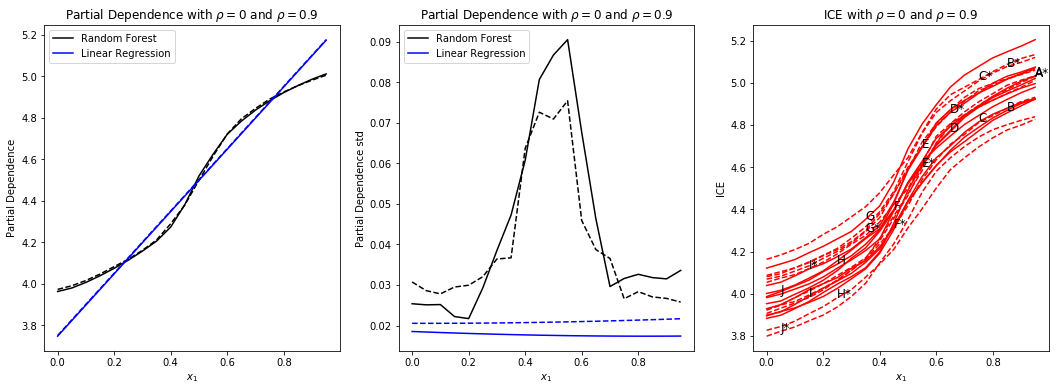

In [123]:
## To plot the result

mean_pd_reg = np.mean(pd_reg, 2)
mean_pd_rf= np.mean(pd_rf, 2)
mean_ice_rf = np.mean(ice_rf, 2)
mean_ice_reg = np.mean(ice_reg, 2)

std_pd_reg = np.std(pd_reg, 2)
std_pd_rf = np.std(pd_rf, 2)

fig, axs = plt.subplots(nrows=1, ncols=3)
ax = axs[0]
ax.plot(x_plot, mean_pd_rf[:,0], color = 'black', label = 'Random Forest')
ax.plot(x_plot, mean_pd_rf[:,1], color = 'black', linestyle = 'dashed')
ax.plot(x_plot, mean_pd_reg[:,0], color = 'blue', label = 'Linear Regression')
ax.plot(x_plot, mean_pd_reg[:,1], color = 'blue', linestyle = 'dashed')
ax.set_title(r'Partial Dependence with $\rho = 0$ and $\rho = 0.9$')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel('Partial Dependence')
ax.legend()


ax = axs[1]
ax.plot(x_plot, std_pd_rf[:,0], color = 'black', label = 'Random Forest')
ax.plot(x_plot, std_pd_rf[:,1], color = 'black', linestyle = 'dashed')
ax.plot(x_plot, std_pd_reg[:,0], color = 'blue', label = 'Linear Regression')
ax.plot(x_plot, std_pd_reg[:,1], color = 'blue', linestyle = 'dashed')
ax.set_title(r'Partial Dependence with $\rho = 0$ and $\rho = 0.9$')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel('Partial Dependence std')
ax.legend()

ax = axs[2]

line_tags = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

for ice_index in range(mean_ice_rf.shape[2]):
  ax.plot(x_plot, mean_ice_rf[:,0, ice_index], color = 'red')
  ax.plot(x_plot, mean_ice_rf[:,1, ice_index], color = 'red', linestyle = 'dashed')
  plot_ind = int(x_plot.shape[0] - ice_index*x_plot.shape[0]/10 -1)
  ax.text(x_plot[plot_ind], mean_ice_rf[:,0, ice_index][plot_ind], line_tags[ice_index], color="black", fontsize=12)
  ax.text(x_plot[plot_ind], mean_ice_rf[:,1, ice_index][plot_ind], line_tags[ice_index] + '*', color="black", fontsize=12)
 

ax.set_title(r'ICE with $\rho = 0$ and $\rho = 0.9$')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel('ICE')





fig.set_size_inches(18, 6, forward=True)
plt.show

From the above Figures we see (dashed is $\rho = 0.9$, straight is $\rho = 0$)
* (Left Figure) The partial dependence does not seems to have a strong relationship with the correlation in this case. This is a little bit different from the Figures in the article though where one could see that there was a stronger relationship between these so that when the correlation increased the behaviour strayed further away from being linear. 
* (Middle Figure) The standard deviation of the model under the highly correlated data appears to be a bit lower, this is a behaviour that they find in the article as well. And the plot looks similar to the one they obtained as well. But why is the standard deviation lower for more correlated data? That seems a bit counter-intuitive.
* (Right Figure) The letters connect the prediction for $\rho=0.9$ (these letters have *) to the one with $\rho=0$. There is no clear pattern between the correlation and the lines, but it can be seen that all features play a similar role on the final prediction. The Figure is a bit different from the one produced in the article. It is also possible to see that the correlation underpredicts for low $x_1$-values and over-predicts for larger $x_1$-values.

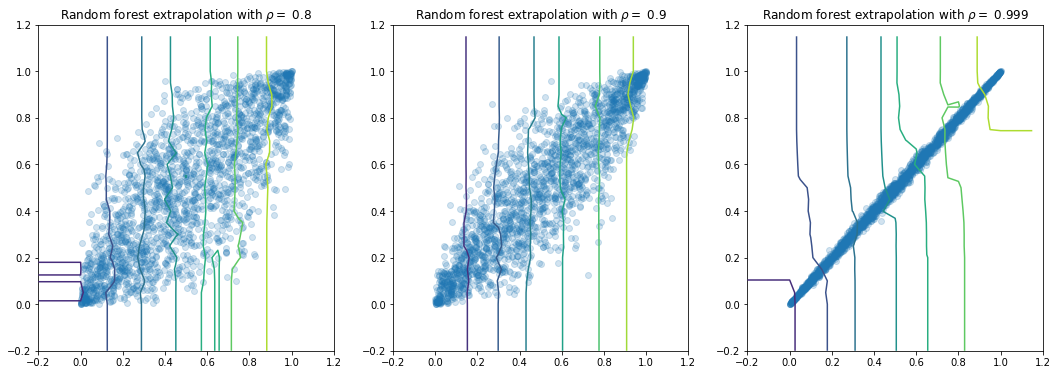

In [207]:
N = 2000 ## Num datapoints
mean_vec = np.zeros(2)
cov_matr = np.ones((2,2))
rho_l = [0.8, 0.9, 0.999]
fig, axs = plt.subplots(nrows=1, ncols=3)

for idx, rho in enumerate(rho_l):
  cov_matr[0,1] = rho
  cov_matr[1,0] = rho
  x1,x2=np.transpose(np.random.multivariate_normal(mean_vec, cov_matr, N))
  x1 = scipy.stats.norm.cdf(x1)
  x2 = scipy.stats.norm.cdf(x2)
  y = x1 + np.random.normal(0,0.05, x1.shape[0])
  X = np.transpose(np.array((x1, x2)))

  x1_plot = np.arange(-0.2,1.2,0.05)
  x2_plot = np.arange(-0.2,1.2,0.05)
  square_grid = np.meshgrid(x1_plot, x2_plot)
  x1_plot_n = np.matrix.flatten(square_grid[0])
  x2_plot_n = np.matrix.flatten(square_grid[1])
  X_square = np.transpose(np.array((x1_plot_n, x2_plot_n)))


  clf = RandomForestRegressor(n_estimators=100)
  clf.fit(X, y)
  rf_predict = clf.predict(X_square)

  
  ax = axs[idx]
  ax.plot(x1,x2, linewidth = 0, marker = 'o', alpha = 0.2, zorder = 2)
  z=np.reshape(rf_predict, (x1_plot.shape[0],x1_plot.shape[0]))
  ax.contour(x1_plot, x2_plot, z, zorder = 4)
  ax.set_xlim(-0.2 ,1.2)
  ax.set_ylim(-0.2 ,1.2)
  ax.set_title(r'Random forest extrapolation with $\rho = $ {}'.format(rho))
fig.set_size_inches(18, 6, forward=True)
plt.show()

From the Figures above we can see that
* The higher the correlation the worse the random forest method extrapolates the behaviour outside the region. The result is not as that observed in the article though where they had curved lines outside the region for lower values of $\rho$. But a similar result is observed for the Figure with $\rho = 0.999$
* I think that a Random forest method might extrapolate well in this example since it only relies on finding the cutting points, and the behaviour described with the cutting points will approximate the true function well since it is constant in $x_2$. Methods such a neural networks would most likely not generalize well in a situation such as this.